In this notebook we inspect the moonboard database and clean the data ready for the machine learning.  First we import some libraries and load the dataframe.

## Importing and cleaning the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re

# Set some default plotting params
%matplotlib inline
sns.set(style="white")
plt.style.use('seaborn-white')
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.figsize'] = (10.0, 8.0)

path_pickle = 'data/database.zip'
df = pd.read_pickle(path_pickle)

Let's first inspect the data and see what we have here.

In [2]:
df.head()

,ApiId,Attempts,DateDeleted,DateInserted,DateTimeString,DateUpdated,FirstAscender,Grade,Holdsets,Holdsetup,...,Name,NameForUrl,NumberOfTries,ProblemType,Rating,RepeatText,Repeats,Setter,UserGrade,UserRating
0,0,0,None,/Date(1542102209893)/,13 Nov 2018 09:43,None,False,6C,None,"{'Id': 15, 'Description': 'MoonBoard Masters 2...",...,WOODEN CENTERPEICE,wooden-centerpeice,None,None,0,Be the first to repeat this problem,0,"{'Id': '9384ECB7-94E4-4B83-AF0D-EE91EE11AB55',...",None,0
1,0,0,None,/Date(1542101683707)/,13 Nov 2018 09:34,None,False,7A+,None,"{'Id': 15, 'Description': 'MoonBoard Masters 2...",...,MUSE IN KOALA,muse-in-koala,None,None,0,1 climber has repeated this problem,1,"{'Id': '9384ECB7-94E4-4B83-AF0D-EE91EE11AB55',...",None,3
2,0,0,None,/Date(1542101635793)/,13 Nov 2018 09:33,None,False,6B+,None,"{'Id': 15, 'Description': 'MoonBoard Masters 2...",...,ORIGINAL TASTE,original-taste,None,None,0,1 climber has repeated this problem,1,"{'Id': '9384ECB7-94E4-4B83-AF0D-EE91EE11AB55',...",None,3
3,0,0,None,/Date(1542094956373)/,13 Nov 2018 07:42,None,False,6A+,None,"{'Id': 15, 'Description': 'MoonBoard Masters 2...",...,SOFT SERVE,soft-serve,None,None,0,Be the first to repeat this problem,0,"{'Id': '33a82150-f883-4f46-a3a7-da776da718dd',...",None,0
4,0,0,None,/Date(1542077121190)/,13 Nov 2018 02:45,None,False,7B+,None,"{'Id': 15, 'Description': 'MoonBoard Masters 2...",...,DOBRA,dobra,None,None,0,Be the first to repeat this problem,0,"{'Id': 'B0794F91-269D-4C5A-8113-366D005A97DD',...",None,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13570 entries, 0 to 13569
Data columns (total 28 columns):
ApiId                       13570 non-null int64
Attempts                    13570 non-null int64
DateDeleted                 0 non-null object
DateInserted                13570 non-null object
DateTimeString              13570 non-null object
DateUpdated                 0 non-null object
FirstAscender               13570 non-null bool
Grade                       13570 non-null object
Holdsets                    0 non-null object
Holdsetup                   13570 non-null object
Id                          13570 non-null int64
IsAssessmentProblem         13570 non-null bool
IsBenchmark                 13570 non-null bool
Locations                   13570 non-null object
Method                      13570 non-null object
MoonBoardConfiguration      13570 non-null object
MoonBoardConfigurationId    13570 non-null int64
Moves                       13570 non-null object
Name         

Let's drop the columns that we aren't interested in.  What we are interested in are the holds/how the moon board is configured, the grade (from the setter and users) and any other interesting bits of data that might be useful later on - such as if it's been repeated or if you are allowed to use holds for your feet or not.  Some columns such as `Holdsets` contain no data.

In [4]:
# create a list of the columns to keep
keep_list = ['Grade', 'Method', 'MoonBoardConfiguration', 'Name',
             'Moves', 'Repeats', 'UserGrade', 'UserRating']
df = df[keep_list]

# try to infer some better dtypes for the columns
df.infer_objects()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13570 entries, 0 to 13569
Data columns (total 8 columns):
Grade                     13570 non-null object
Method                    13570 non-null object
MoonBoardConfiguration    13570 non-null object
Name                      13570 non-null object
Moves                     13570 non-null object
Repeats                   13570 non-null int64
UserGrade                 4541 non-null object
UserRating                13570 non-null int64
dtypes: int64(2), object(6)
memory usage: 848.2+ KB


,Grade,Method,MoonBoardConfiguration,Name,Moves,Repeats,UserGrade,UserRating
0,6C,Feet follow hands,"{'Id': 1, 'Description': '40° MoonBoard', 'Low...",WOODEN CENTERPEICE,"[{'Id': 1820187, 'Description': 'C5', 'IsStart...",0,None,0
1,7A+,Feet follow hands,"{'Id': 1, 'Description': '40° MoonBoard', 'Low...",MUSE IN KOALA,"[{'Id': 1820182, 'Description': 'H5', 'IsStart...",1,None,3
2,6B+,Feet follow hands,"{'Id': 1, 'Description': '40° MoonBoard', 'Low...",ORIGINAL TASTE,"[{'Id': 1820175, 'Description': 'I3', 'IsStart...",1,None,3
3,6A+,Feet follow hands + screw ons,"{'Id': 1, 'Description': '40° MoonBoard', 'Low...",SOFT SERVE,"[{'Id': 1820161, 'Description': 'F5', 'IsStart...",0,None,0
4,7B+,Footless + kickboard,"{'Id': 1, 'Description': '40° MoonBoard', 'Low...",DOBRA,"[{'Id': 1820081, 'Description': 'G5', 'IsStart...",0,None,0


There are a couple of different configurations to the moon board but we will only keep the most popular one (where it's at a 40° overhang).  There are are a couple of different possibilities for footholds but again we'll only keep the most popular.

In [5]:
# Replace MoonBoardConfiguration column by Id in it's dictionary and then only keep Id == 1.
# This means that we're only keeping the 40° MoonBoard (the most popular one)
df['MoonBoardConfiguration'] = df['MoonBoardConfiguration'].apply(
    lambda d: d['Id'])
df = df[(df['MoonBoardConfiguration'] == 1) &
        (df['Method'] == 'Feet follow hands')]
df = df.drop(columns=['MoonBoardConfiguration', 'Method'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10983 entries, 0 to 13569
Data columns (total 6 columns):
Grade         10983 non-null object
Name          10983 non-null object
Moves         10983 non-null object
Repeats       10983 non-null int64
UserGrade     3674 non-null object
UserRating    10983 non-null int64
dtypes: int64(2), object(4)
memory usage: 600.6+ KB


In [6]:
df.head()

,Grade,Name,Moves,Repeats,UserGrade,UserRating
0,6C,WOODEN CENTERPEICE,"[{'Id': 1820187, 'Description': 'C5', 'IsStart...",0,None,0
1,7A+,MUSE IN KOALA,"[{'Id': 1820182, 'Description': 'H5', 'IsStart...",1,None,3
2,6B+,ORIGINAL TASTE,"[{'Id': 1820175, 'Description': 'I3', 'IsStart...",1,None,3
5,6B+,JASON ADAMS,"[{'Id': 1820074, 'Description': 'D5', 'IsStart...",0,None,0
6,6C+,PUNK SNUGGLE,"[{'Id': 1820066, 'Description': 'G8', 'IsStart...",0,None,0


We now have the two main bits of data that we need to clean and move into the correct format: the grade and the holds used.  For the grade we will convert the font grade (a climbing grade) to a numerical grade with 1 being the easiest.  The font grading system first has a number grade which is then subdivided into 3 letters (A, B, C) and then further subdivided with either have a `+` or not.

In [7]:
# First make a list of the grades (removing the Nones from the 'UserGrade' col)
grade_list_user = df['UserGrade'].dropna().unique()
grade_list = np.union1d(df['Grade'].unique(), grade_list_user)
grade_dict = dict((k, v) for v, k in enumerate(grade_list))
# Keep the Nones as Nones for the UserGrade
grade_dict['None'] = None

df['Grade_num'] = df['Grade'].apply(lambda x: grade_dict[x])
df['UserGrade_num'] = df['UserGrade'].apply(lambda x: grade_dict[str(x)])
df.head()

,Grade,Name,Moves,Repeats,UserGrade,UserRating,Grade_num,UserGrade_num
0,6C,WOODEN CENTERPEICE,"[{'Id': 1820187, 'Description': 'C5', 'IsStart...",0,None,0,3,NaN
1,7A+,MUSE IN KOALA,"[{'Id': 1820182, 'Description': 'H5', 'IsStart...",1,None,3,6,NaN
2,6B+,ORIGINAL TASTE,"[{'Id': 1820175, 'Description': 'I3', 'IsStart...",1,None,3,2,NaN
5,6B+,JASON ADAMS,"[{'Id': 1820074, 'Description': 'D5', 'IsStart...",0,None,0,2,NaN
6,6C+,PUNK SNUGGLE,"[{'Id': 1820066, 'Description': 'G8', 'IsStart...",0,None,0,4,NaN


Now we come to wrangling the `Moves` column.  This column should specify an ordered list of the climbing holds to be used for each route, including which holds to start and finish one.  Furthermore, it also gives the order in which the holds should be used.  For the majority of problems this order shouldn't matter so for simplicity we will ignore the order.  We will see later that this means we can interpret the holds to be used as a picture and use a CNN (convolution neutral network) to classify routes (pictures) according to their grades.  If we included the ordering then it would be best to use a RNN (recurrent neural network), namely a Long short-term memory (LSTM), instead.  We will leave this as further work which may give better classification accuracy.

We shall convert the `Moves` into a 3-dim array with the two dimension indicating the holds on the board (an 18 x 11 grid) and the 3rd dimension indicating if the hold used is a starting hold, finishing hold or just a hold used in the middle of the sequence.  The 3rd dimension will be ordered (is_middle, is_start, is_end).

An example the move `{'Id': 1811895, 'Description': 'C10', 'IsStart': True, 'IsEnd': False}` implies `moves_array[3, 10, 1] = 1`

In [8]:
df.Moves.iloc[0]

[{'Id': 1820187, 'Description': 'C5', 'IsStart': True, 'IsEnd': False},
 {'Id': 1820188, 'Description': 'F6', 'IsStart': True, 'IsEnd': False},
 {'Id': 1820189, 'Description': 'D9', 'IsStart': False, 'IsEnd': False},
 {'Id': 1820190, 'Description': 'G12', 'IsStart': False, 'IsEnd': False},
 {'Id': 1820191, 'Description': 'C14', 'IsStart': False, 'IsEnd': False},
 {'Id': 1820192, 'Description': 'C16', 'IsStart': False, 'IsEnd': False},
 {'Id': 1820193, 'Description': 'A18', 'IsStart': False, 'IsEnd': True}]

In [9]:
def move_coordinate(d):
    # convert a move to the coorindates of the hold on the board
    s_split = re.split('(\d+)', d['Description'], maxsplit=1)
    # extra `-1` in both for 0 indexing
    w = ord(s_split[0].upper()) - 64 - 1
    h = int(s_split[1]) - 1
    if d['IsStart'] == True:
        z = 1
    elif d['IsEnd'] == True:
        z = 2
    else:
        z = 0
    return (h, w, z)


def convert_moves(moves):
    array = np.zeros((18, 11, 3))
    for move in moves:
        array[move_coordinate(move)] = 1
    return array


df['Moves_array'] = df['Moves'].apply(convert_moves)

In [10]:
# Quick check that we've created the array we expected to
df.Moves_array.iloc[0][:, :, 0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
df.head()

,Grade,Name,Moves,Repeats,UserGrade,UserRating,Grade_num,UserGrade_num,Moves_array
0,6C,WOODEN CENTERPEICE,"[{'Id': 1820187, 'Description': 'C5', 'IsStart...",0,None,0,3,NaN,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,7A+,MUSE IN KOALA,"[{'Id': 1820182, 'Description': 'H5', 'IsStart...",1,None,3,6,NaN,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,6B+,ORIGINAL TASTE,"[{'Id': 1820175, 'Description': 'I3', 'IsStart...",1,None,3,2,NaN,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
5,6B+,JASON ADAMS,"[{'Id': 1820074, 'Description': 'D5', 'IsStart...",0,None,0,2,NaN,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
6,6C+,PUNK SNUGGLE,"[{'Id': 1820066, 'Description': 'G8', 'IsStart...",0,None,0,4,NaN,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


## Visualising the data

Let's see a pictures of what the `Moves_array` looks like.  Orange holds are the normal (middle) holds, green holds are the starting holds and blue holds are the finishing holds.

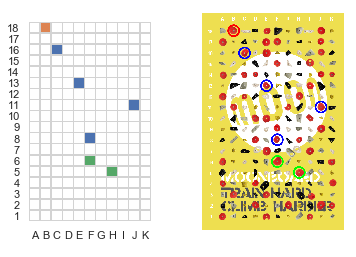

In [69]:
def plot_move(array):
    # takes a 3d array of moves and plots which holds are used
    with sns.axes_style("white"):
        f, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.5]})
        mask = np.ones((18, 11))
        mask[np.sum(array, axis=2) != 0] = False
        color = np.array([-1, 1, 0])
        data = np.sum(array*color, axis=2)

        cmap = sns.color_palette(n_colors=4)
        # The labels A to K
        xticklabels = [chr(i) for i in range(65, 65+11)]

        sns.heatmap(data, linewidths=0.5, square=True, mask=mask, yticklabels=range(1, 19), xticklabels=xticklabels,
                    center=1, cbar=False, ax=axes[0], cmap=cmap, linecolor='lightgrey').invert_yaxis()
        img = mpimg.imread('REDLINE.png')
        plt.imshow(img, origin='upper')
        axes[-1].axis('off')
#         f.savefig('REDLINE.pdf', dpi=1000, bbox_inches='tight')


plot_move(df[df.Name == 'REDLINE'].Moves_array.iloc[0])

We now visualise some of the data and take a peek at it.  We first have a look at the distribution of grades and see that most of the routes are for the lower grades with very few routes in the 8's. We will take the `Grade`, which is given by each individual setter, as the truth but there is likely to be some noise here.  Something that we will show later on.

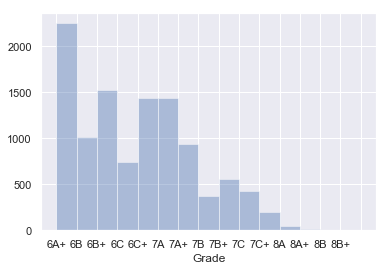

In [44]:
sns.set(style="darkgrid")
bins = range(len(grade_list)+1)
sns.distplot(df.Grade_num, bins=bins, kde=False, axlabel="Grade")
plt.xticks(bins, grade_list);

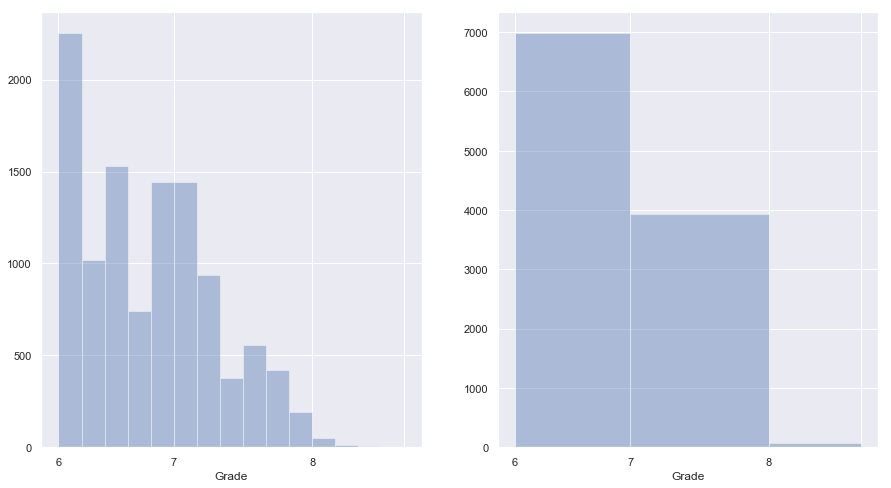

In [14]:
bin_list = [0, grade_dict['7A'], grade_dict['8A'], len(grade_list)]
grade_cum_list = ["6", "7", "8"]


def plot_dual_dist_hist():
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    sns.distplot(df.Grade_num, bins=bins, kde=False,
                 axlabel="Grade", ax=axes[0])
    sns.distplot(df.Grade_num, bins=bin_list,
                 kde=False, axlabel="Grade", ax=axes[1])
    for a in axes:
        a.set_xticks([0, grade_dict['7A'], grade_dict['8A'], len(grade_list)])
        a.set_xticklabels(grade_cum_list)
    return fig, axes


plot_dual_dist_hist();

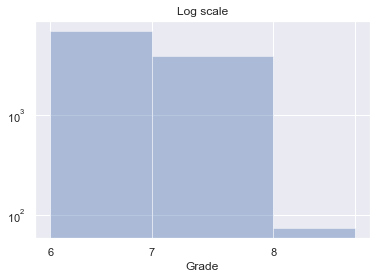

In [15]:
sns.distplot(df.Grade_num, bins=bin_list, kde=False, axlabel="Grade")
plt.xticks(bin_list, grade_cum_list)
plt.title('Log scale')
plt.yscale('log')

Now visualise a heatmap of which holds are used for which grades of climbs.  We split them up into below 6C+, 7A-7C+, and 8A and above.

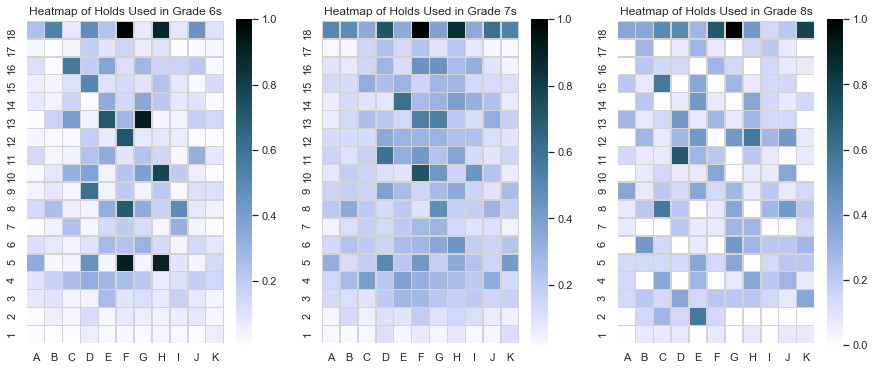

In [77]:
# Create masks to show the different number grades
mask_grade_6s = df.Grade_num < grade_dict['7A']
mask_grade_7s = (
    df.Grade_num > grade_dict['6C+']) & (df.Grade_num < grade_dict['8A'])
mask_grade_8s = df.Grade_num > grade_dict['7C+']
masks = [mask_grade_6s, mask_grade_7s, mask_grade_8s]

# Sum the moves for each number grade
cum_moves = np.zeros((3, 18, 11))
for i, mask in enumerate(masks):
    cum_moves[i] = np.sum(np.sum(df[mask].Moves_array, axis=0), axis=-1)

# Plot a heatmap of the holds used
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
xticklabels = [chr(i) for i in range(65, 65+11)]
cmap = sns.cubehelix_palette(
    start=2.4, rot=0.2, light=0.99, dark=0.01, hue=1, as_cmap=True)

for i, move in enumerate(cum_moves):
    # normalise the cumlative move to [0,1]
    move_norm = move / np.max(move)
    sns.heatmap(move_norm, linewidths=0.5, square=True, yticklabels=range(1, 19),
                xticklabels=xticklabels, center=0.5, cmap=cmap, ax=axes[i],
                linecolor='lightgrey').invert_yaxis()
    axes[i].set_title("Heatmap of Holds Used in Grade " +
                      grade_cum_list[i] + "s")
# fig.savefig('heatmap.pdf', dpi=1000, bbox_inches='tight')

As you can see, different holds are favoured by different grades of route, with the exception of some of the finishing holds.  The finishing holds on hard climbing routes can often be very large and easy to hold onto so this is to be expected.  The grade 7's are the most uniform in terms of holds used, although there is a clustering effect in the center.  We would expect this bias since the climber would generally prefer to stay closer to the middle of the board and not fall off the edge.  If this was a subsample of a larger moonboard then we wouldn't see this.
There isn't a large set of grade 8's and hence part of the spotted effect might come from the small sample size, however we would also expect to be an actual feature in the data since the harder routes won't use the easier holds.  Further discussion could be had in this area looking into the different holdsets that make up the board, with some holdsets being harder to grip than others.

## Accuracy of human graders

Before we train a CNN (convolution neural network) to classify the difficulty of a given route we investigate the quality of the grading in the data.  We have two grades available to us: the `UserGrade` a crowd sourced grade from climbers who have climbed this route, and the `Grade` which is the grade given to the climb by whoever set the route.  Only a third of the climbs have been graded by other climbers and a fair proportion of the routes have had little to no repeats.  The climbers who set the route are not necessarily more experienced that other users and there is some argument to be made that, for routes than have been graded enough, the `UserGrade` will be the more accurate grade.  However, we expect both grades to approximately agree - be within 1 grade of each other.  Let's see if this is true.  For now we take the `Grade` to be the truth.

In [71]:
df_user_grade = df.dropna(subset=['UserGrade'])
user_grade_percent = df.UserGrade.count() / df.Grade.count() * 100
repeat_percent = df.Repeats[df.Repeats > 1].count() / df.Repeats.count() * 100
print(f"Only {user_grade_percent:.0f}% of routes have been graded by other climbers.")
print(f"Only {repeat_percent:.0f}% of routes have only been repeated more than once by other climbers.")

acc = np.zeros(3)
for i in range(3):
    acc[i] = np.sum(np.abs(df_user_grade.Grade_num -
                           df_user_grade.UserGrade_num) <= i) / len(df_user_grade.Grade_num)

acc_pd = pd.DataFrame(
    acc, ["Accuracy (exact)", "Accuracy (within 1 grade)", "Accuracy (within 2 grades)"])
print(acc_pd.to_string(header=False))

Only 33% of routes have been graded by other climbers.
Only 63% of routes have only been repeated more than once by other climbers.
Accuracy (exact)            0.954545
Accuracy (within 1 grade)   0.971965
Accuracy (within 2 grades)  0.992107


This gives us an idea of the noise in the `Grade` data.  The climbers who gave these climbs the `UserGrade` also climbed the routes.  Our model will only look at the route and so we expect to see worse accuracy than this.  Since climbing grades by their nature are often subject (and it's not uncommon for routes to go up or down a couple of grades) we use the `Accuracy (within 1 grade)` as our metric.  Later we also include how far out we are in our loss function instead of the usual right or wrong - this allows us to take into account that we are classifying on a linear scale and not just to arbitrary labels.

## Saving the data for training

In the [next notebook](CNN.ipynb) we train a convolution neural network to grade the routes from only seeing the moves - the climbers who graded the route also were able to climb them so have a big advantage! Finally we save the data as numpy arrays.  The moves data has the shape `(batch, h, w, hold_type) = (:, h, w, 3)`.  We will be taking stratified samples so that the train, validate and test datasets contain the same distribution of grade 6, 7 and 8 climbs.  The main worry is that there are so little grade 8 climbs that one of the datasets could see a disproportionate amount of them.

In [18]:
# save the arrays sorted by grade
df = df.sort_values(by='Grade_num')
df_user_grade = df.dropna(subset=['UserGrade'])

def save_data(df, path):
    moves = np.concatenate(df.Moves_array.values)
    moves = moves.reshape((-1, 18, 11, 3))
    # cast grades to np.int32
    grades = df.Grade_num.values.astype(np.int32)

    np.savez_compressed(path, moves=moves,
                        grades=grades, grade_dict=grade_dict)


# save both all the data and only the moves that have been graded by users as well (and we know the accuracy of)
save_data(df, 'data/data.npz')
save_data(df_user_grade, 'data/data_user.npz')

# Also save the cleaned and processed dataset
df.to_pickle('data/database_processed.zip')